In [143]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn
import torch

import math

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Изучение данных

In [144]:
sig, sr = librosa.load('Стрельба на улице.wav', sr=None)
#sig, sr = librosa.load('Стрельба на улице.wav')

In [145]:
sr

16000

In [146]:
# График waveform

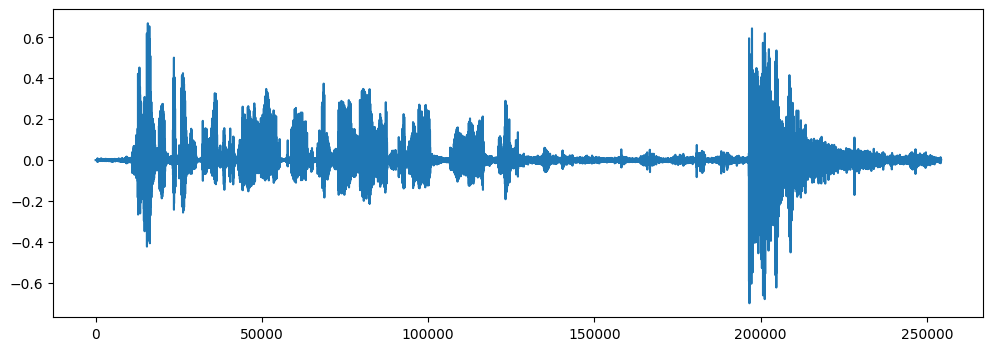

In [147]:
plt.figure(figsize=(12, 4))
plt.plot(sig)

Резкий скачок амплитуды во второй половине аудиозаписи - момент выстрела.

### Анализ окон STFT

In [148]:
# Размер окна = 0.5 секунд

window_ms = 500
n_fft = window_ms * sr // 1000

fragments = np.abs(librosa.stft(sig, n_fft=n_fft, hop_length = n_fft // 2, window='hann', center=True))
means = fragments.mean(axis=0)

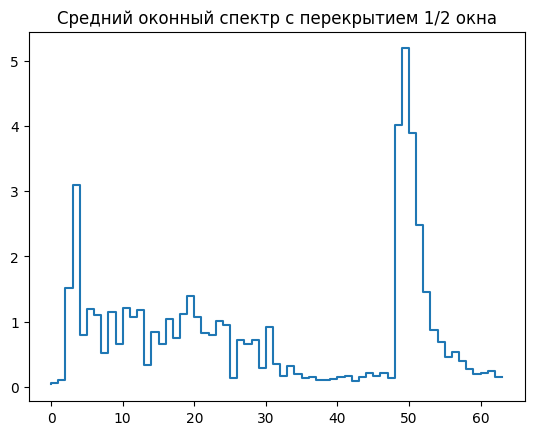

In [149]:
x = np.arange(means.shape[0])
y = means

plt.step(x, y, label='pre (default)')

plt.title('Средний оконный спектр с перекрытием 1/2 окна')
plt.show()

Text(0.5, 1.0, 'Спектрограмма (перекрытие 1/2 окна)')

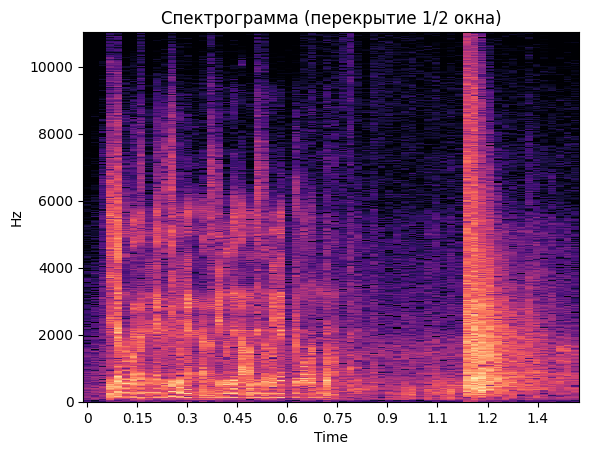

In [150]:
fig, ax = plt.subplots()
stft = librosa.amplitude_to_db(fragments, ref=np.max)

img = librosa.display.specshow(stft, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Спектрограмма (перекрытие 1/2 окна)')

#### По спектрограмме видно, что выстрел отличается от речи и шума сильной интенсивностью сигнала в районе от ~50 до 3000 Гц

## Процесс детектирования

In [151]:
fragments = np.abs(librosa.stft(sig, n_fft=n_fft, hop_length = n_fft // 2, window='hann', center=True))

In [152]:
len(fragments)

4001

In [153]:
def detection(signal, sr, n_fft, hop_len, threshold):
    
    fragments = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length = hop_len, window='hann', center=True))
    
    bins = fragments.sum(axis=0)
    
    res = np.intc(bins > threshold)
    res = np.repeat(res, hop_len)

    if (len(signal) - len(res)) > 0:
            res = np.pad(res, len(signal) - len(res))[len(signal) - len(res):]
    else:
            res = res[:len(signal)]
     
    dist = bins[98] - bins[8]
    return res, dist

res, dist = detection(sig, sr, n_fft, n_fft // 4, 15000)
print('Минимальная дистанция между шумом и выстрелом = ', int(dist))

Минимальная дистанция между шумом и выстрелом =  3666


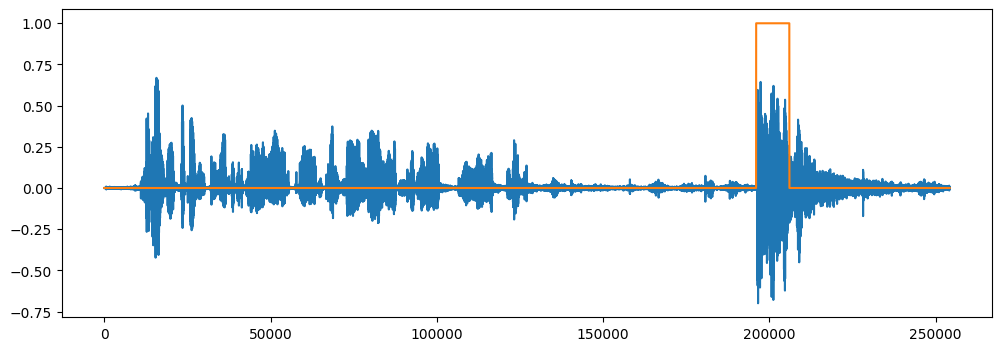

In [154]:
plt.figure(figsize=(12, 4))

plt.plot(sig)
plt.plot(res)

При проверке бинов получается, что разница между максимумом шума и минимумом выстрела равна 3666.
Вероятно результаты можно улучшить наложив фильтр нижних частот.

## Использование фильтра

In [155]:
from scipy import signal

Попробуем применить фильтр (НЧ) на значения выше 3000 Гц

In [156]:
filtering = signal.butter(10, 3000, 'lp', fs=sr, output='sos')
filtered_signal = signal.sosfilt(filtering, sig)

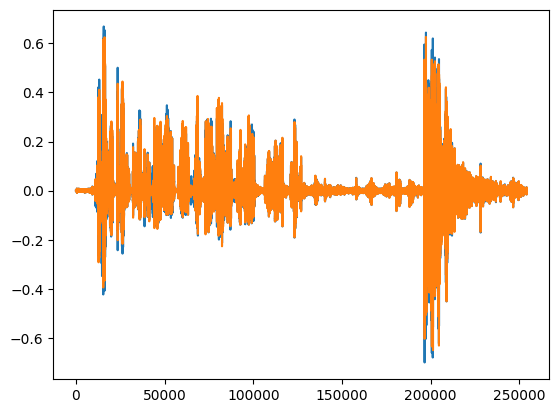

In [157]:
plt.plot(sig)
plt.plot(filtered_signal)

In [158]:
# После фильтрации
ipd.Audio(filtered_signal, rate=sr)

In [159]:
# Оригинальный сигнал
ipd.Audio(sig, rate=sr)

После фильтрации шумовые фрагменты аудио потеряли в амплитуде больше, чем выстрел. Тем не менее, он тоже изменился, нужно будет подобрать новый порог. 

In [160]:
res, dist = detection(filtered_signal, sr, n_fft, n_fft // 4, 11000)
print('Минимальная дистанция между шумом и выстрелом =', int(dist))

Минимальная дистанция между шумом и выстрелом = 2209


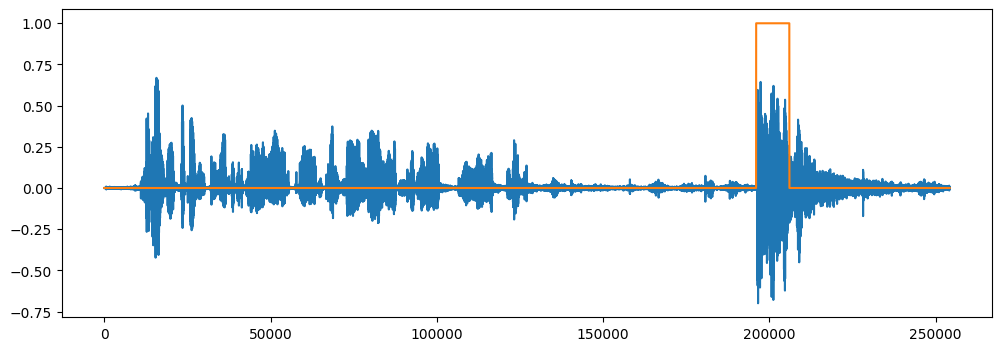

In [161]:
plt.figure(figsize=(12, 4))

plt.plot(sig)
plt.plot(res)

## Выводы

По советам из лекции был реализован детектор выстрела по амплитуде сигнала с использованием оконного преобразования Фурье с 50% наложением окна. Детектор показывает довольно неплохую точность.
Был также использован фильтр Нижних Частот для повышения точности детектора.
В первом случае дистанция между выстрелом и шумом была 3666, а после применения фильтра стала 2209. Это можно считать улучшением, хотя и не сильно большим. Для более зашумленной записи разница может быть намного значительнее.